# Chapter6 : Deep learning for test and sequences

## 6.2 Understanding recurrent neural networks

A major characteristic of all neural networks you've seen so far, such as densely connected networks and convnets, is that they have no memory. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once. Such networks are called ***feedforward networks***.

In contrast, biological intelligence processes information incrementally while maintaining an internal model of what it's processing, built from past information and constantly updated as new information comes in.

A ***recurrent neural network (RNN)*** adpots the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a **state** containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop. The data point is no longer processed in a single step; rather, the network internally loops over sequence elements.

<img src='image/rnn.png' width="250">

#### Pseudocode RNN

In [ ]:
state_t = 0    # the state at t
for input_t in input_sequence:   # iterates over sequence elements
    output_t = f(input_t, state_t)
    state_t = output_t    # the previous output becomes the state
                          # for the next iteration

#### More detailed pseudocode for the RNN

In [ ]:
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

#### Numpy implementation of a simple RNN

In [3]:
import numpy as np

In [4]:
timesteps = 100        # number of timesteps in the input sequence
input_features = 32    # dimensionality of the input feature space
output_features = 64   # dimensionality of the output feature space

In [6]:
# input data: random noise for the sake of the example
inputs = np.random.random((timesteps, input_features))

In [7]:
# inital state: an all-zero vector
state_t = np.zeros((output_features,))

In [10]:
# Creates random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

In [11]:
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
    
final_output_sequence = np.concatenate(successive_outputs, axis=0)

> In summary, an RNN is a **for** loop that reuses quantities computed during the previous iteration of the loop.

<img src='image/rnn2.png' width='600'>

In [13]:
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

> In many cases, you don't need this full sequence of outputs; you just need the last output, because it already contains information about the entire sequence.

### 6.2.1 A recurrent layer in Keras

The process you just naively implemented in Numpy corresponds to an actual Keras layer--the **SimpleRNN** layer

In [14]:
from keras.layers import SimpleRNN

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


Like all recurrent layers in Keras, **SimpleRNN** can be run in two different modes:
  + return the full sequences of successive outputs for each timestamp
  + return only the last output for each input sequence

##### The following example returns the full state sequence:

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [20]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


#### Preparing the IMDB data

In [21]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [22]:
max_features = 10000
maxlen = 500
batch_size = 32

In [24]:
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [26]:
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


#### Training the model with $Embedding$ and $SimpleRNN$ layers

In [27]:
from keras.layers import Dense

In [28]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 37s - loss: 0.6432 - acc: 0.6130 - val_loss: 0.4804 - val_acc: 0.8006
Epoch 2/10
 - 33s - loss: 0.4051 - acc: 0.8276 - val_loss: 0.7622 - val_acc: 0.6920
Epoch 3/10
 - 34s - loss: 0.2970 - acc: 0.8820 - val_loss: 0.4377 - val_acc: 0.7960
Epoch 4/10
 - 34s - loss: 0.2257 - acc: 0.9139 - val_loss: 0.3863 - val_acc: 0.8332
Epoch 5/10
 - 35s - loss: 0.1596 - acc: 0.9415 - val_loss: 0.3645 - val_acc: 0.8596
Epoch 6/10
 - 34s - loss: 0.1021 - acc: 0.9662 - val_loss: 0.3915 - val_acc: 0.8684
Epoch 7/10
 - 34s - loss: 0.0688 - acc: 0.9781 - val_loss: 0.4607 - val_acc: 0.8410
Epoch 8/10
 - 38s - loss: 0.0392 - acc: 0.9888 - val_loss: 0.5466 - val_acc: 0.8224
Epoch 9/10
 - 37s - loss: 0.0294 - acc: 0.9910 - val_loss: 0.6691 - val_acc: 0.7906
Epoch 10/10
 - 35s - loss: 0.0173 - acc: 0.9949 - val_loss: 0.7691 - val_acc: 0.7870


#### Plotting resultsm

In [30]:
import matplotlib.pyplot as plt

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

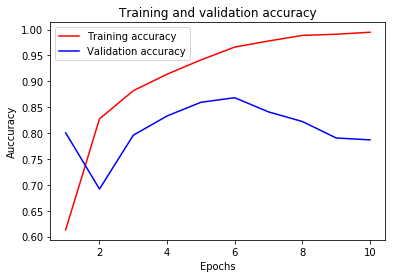

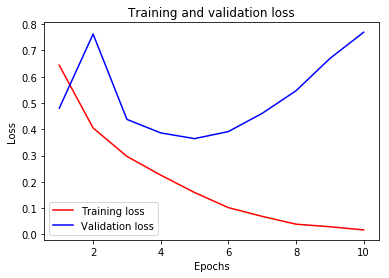

In [32]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Auccuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> This small recurrent network doesn't perform well compared to this baseline (only 80% validation accuracy). Part of the problem is that your inputs only consider the first 500 words, rather than the full sequences--hence, the RNN has access to less information than the earlier baseline model. The remainder of the problem is that SimpleRNN isn't good at processing long sequences, such as text.

* Other types of recurrent layers perform much better. Let's look at some more advanced layers.

### 6.2.2 Understanding the LSTM and GRU layers

**SimpleRNN** sn't the only recurrent layer available in Keras. There are two others: **LSTM** and **GRU**.

**SimpleRNN** has a major issue: although it should theoretically be able to retain at time *t* information about inputs seen many timesteps before, in practice, such long-term dependencies are impossible to learn. This is due to the *vanishing gradient problem*, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable.

Let's consider the **LSTM** layer. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.

#### Pseudocode details of the LSTM architecture (1/2)

In [ ]:
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

#### Pseudocode details of the LSTM architecture (2/2)

* You obtain the new carry state (the next c_t) by combining i_t, f_t, and k_t.

In [ ]:
c_t+1 = i_t * k_t + c_t * f_t

<img src='image/lstm2.png' width='600'>

> Keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

### 6.2.3 A concrete LSTM example in Keras

#### Using the LSTM in Keras

In [34]:
from keras.layers import LSTM

In [35]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 113s - loss: 0.5122 - acc: 0.7602 - val_loss: 0.4103 - val_acc: 0.8228
Epoch 2/10
 - 108s - loss: 0.2930 - acc: 0.8861 - val_loss: 0.4396 - val_acc: 0.8000
Epoch 3/10
 - 117s - loss: 0.2333 - acc: 0.9103 - val_loss: 0.3466 - val_acc: 0.8806
Epoch 4/10
 - 103s - loss: 0.1963 - acc: 0.9259 - val_loss: 0.3292 - val_acc: 0.8704
Epoch 5/10
 - 107s - loss: 0.1724 - acc: 0.9364 - val_loss: 0.3436 - val_acc: 0.8772
Epoch 6/10
 - 110s - loss: 0.1565 - acc: 0.9432 - val_loss: 0.5724 - val_acc: 0.8074
Epoch 7/10
 - 118s - loss: 0.1405 - acc: 0.9482 - val_loss: 0.6250 - val_acc: 0.8366
Epoch 8/10
 - 120s - loss: 0.1293 - acc: 0.9558 - val_loss: 0.3312 - val_acc: 0.8846
Epoch 9/10
 - 115s - loss: 0.1149 - acc: 0.9611 - val_loss: 0.3433 - val_acc: 0.8876
Epoch 10/10
 - 116s - loss: 0.1066 - acc: 0.9620 - val_loss: 0.3915 - val_acc: 0.8852


In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

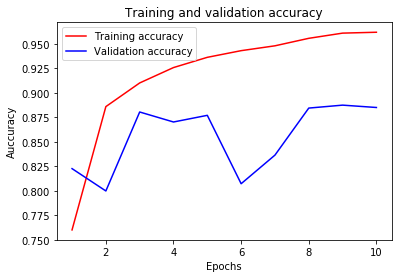

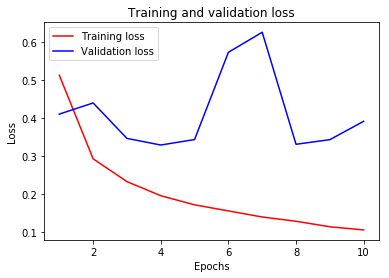

In [37]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Auccuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> This time, you achieve up to 89% validation accuracy. Certainly much better than the SimpleRNN network--that's because LSTM suffers much less from the vanishing-gradient problem--and slightly better than the fully connected approach from chapter 3, even though you're looking at less data than you were in chapter 3.

But why isn't LSTM performing much better? There are a couple of reasons:
  + You made no effort to tune hyperparameters such as the embeddings dimensionality or the LSTM output dimensionality.
  + Lack of regularization.
  + Analyzing the global, long-term structure of the reviews (what LSTM is good at) isn't helpful for a sentiment-analysis problem.
  
Still, there are far more difficult natural-language-processing problems out there, where the strength of LSTM will become apparent: in particular, question-answering and machine translation.